# Extraction of volatility surface parameters $\beta_i\;\forall\;i\in\{1, 2, 3, 4, 5\}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from notebooks.utils import plot_beta
import warnings

In [2]:
df = pd.read_parquet('../data.nosync/data.parquet')
df.dropna(inplace=True, how='any')

## Estimation of parameters

Estimation for Beta Parameters

OLS Model：

$$
\sigma(M, \tau)=\beta_1 + \beta_2\times(\text{Time to maturity slope}) + \beta_3\times(\text{Moneyness slope}) + \beta_4\times(\text{Smile attenuation})+\beta_5\times(\text{Smirk})
$$

Parameters:
- $T_{max} = 5 \text{ years}$
- $T_{conv} = 0.25 \text{ years}$

In [3]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

T_MAX = 5
T_CONV = 0.25
lambda_vec = np.array([1, 1, 30, 40, 40])
R = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
])

results = []
prev_b3, prev_b4, prev_b5 = 0, 0, 0

for date, daily_data in df.groupby("date", sort=True):
    # --- Priors ---
    atm_1y = daily_data.loc[(daily_data["YTM"] == 1.0) & (daily_data["M"] == 0), "impl_volatility"].mean()
    atm_1m = daily_data.loc[(daily_data["YTM"] == 1 / 12) & (daily_data["M"] == 0), "impl_volatility"].mean()
    atm_1y = 0.0 if np.isnan(atm_1y) else atm_1y
    atm_1m = 0.0 if np.isnan(atm_1m) else atm_1m
    beta_prior = np.array([
        atm_1y,
        (atm_1y - atm_1m) / np.exp(-np.sqrt(4 / 12)),
        prev_b3,
        prev_b4,
        prev_b5,
    ])
    # --- Features ---
    YTM = daily_data["YTM"].to_numpy()
    M = daily_data["M"].to_numpy()
    vol = daily_data["impl_volatility"].to_numpy()
    X = np.column_stack([
        np.ones(len(daily_data)),  # X1
        np.exp(-np.sqrt(YTM / T_CONV)),  # X2
        np.where(M < 0, np.tanh(M), M),  # X3
        (1 - np.exp(-M ** 2)) * np.log(YTM / T_MAX),  # X4
        np.where(M < 0, (1 - np.exp((3 * M) ** 3)) * np.log(YTM / T_MAX), 0),  # X5
    ])
    # --- Augmented system ---
    X_aug = np.vstack((X, np.diag(lambda_vec) @ R))
    Y_aug = np.concatenate((vol, lambda_vec * beta_prior))
    # --- Solve least squares ---
    beta_hat, *_ = np.linalg.lstsq(X_aug, Y_aug, rcond=None)
    # --- Save and propagate priors ---
    prev_b3, prev_b4, prev_b5 = beta_hat[2], beta_hat[3], beta_hat[4]
    results.append((date, *beta_hat))

beta = pd.DataFrame(results, columns=["date", "beta1", "beta2", "beta3", "beta4", "beta5"])
beta.to_parquet('../data.nosync/beta.parquet', engine='fastparquet', index=False)
beta

,date,beta1,beta2,beta3,beta4,beta5
0,2000-08-31,0.209443,-0.033085,0.003102,-0.005289,-0.002869
1,2000-09-01,0.206923,-0.017983,0.006191,-0.011377,-0.006313
2,2000-09-05,0.194020,0.067232,0.015366,-0.020927,-0.003105
3,2000-09-06,0.205208,0.000788,0.018398,-0.026022,-0.003734
4,2000-09-07,0.198713,0.029166,0.025915,-0.033422,-0.000516
...,...,...,...,...,...,...
5781,2023-08-25,0.201611,-0.142457,0.225539,-0.029057,-0.045927
5782,2023-08-28,0.202365,-0.149166,0.222393,-0.026056,-0.044353
5783,2023-08-29,0.199807,-0.155747,0.214850,-0.033763,-0.052378
5784,2023-08-30,0.200782,-0.165996,0.212386,-0.035851,-0.050152


## Plotting of parameters

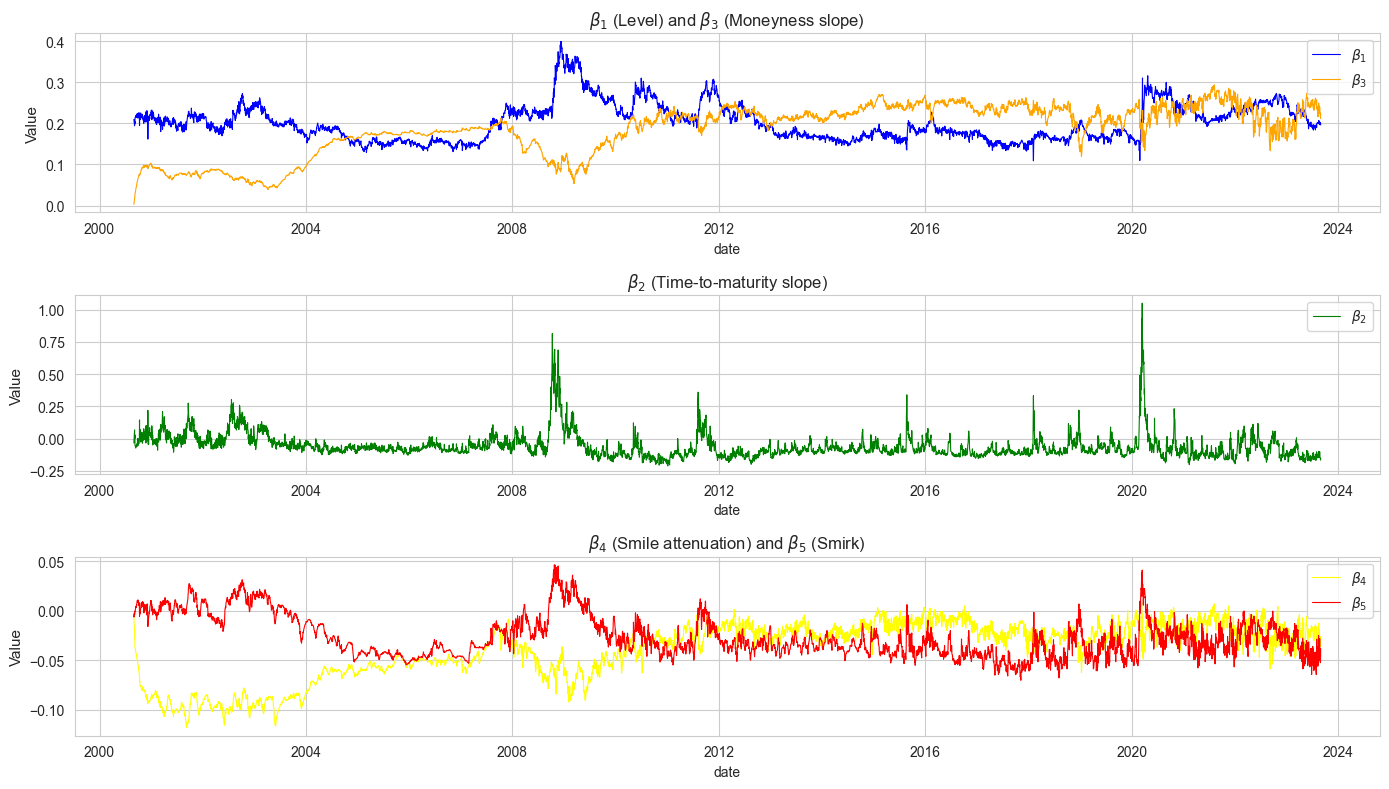

In [4]:
plot_beta(beta)

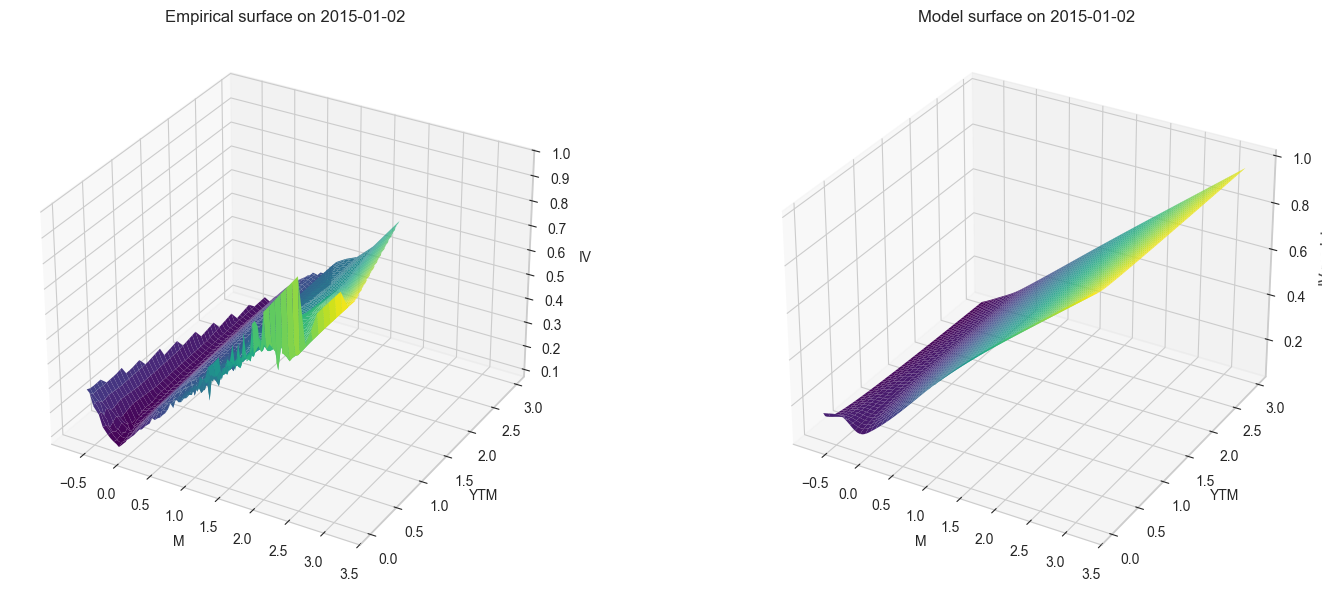

In [5]:
day = pd.Timestamp("2015-01-02")
# empirical data for that day
df_day = df[df["date"] == day].dropna(subset=["impl_volatility", "M", "YTM"]).copy()
# grid for both surfaces
M_vals = np.linspace(df_day["M"].min(), df_day["M"].max(), 100)
T_vals = np.linspace(df_day["YTM"].min(), df_day["YTM"].max(), 100)
M_grid, T_grid = np.meshgrid(M_vals, T_vals)
# empirical surface
points = df_day[["M", "YTM"]].values
values = df_day["impl_volatility"].values
IV_emp = griddata(points, values, (M_grid, T_grid), method="linear")
# load betas for the chosen date
b_row = beta.loc[beta["date"] == day]
b1 = float(b_row["beta1"].iloc[0])
b2 = float(b_row["beta2"].iloc[0])
b3 = float(b_row["beta3"].iloc[0])
b4 = float(b_row["beta4"].iloc[0])
b5 = float(b_row["beta5"].iloc[0])
# model surface components
term1 = b1
term2 = b2 * np.exp(-np.sqrt(T_grid / T_CONV))
term3 = b3 * np.where(M_grid >= 0, M_grid, (np.exp(2 * M_grid) - 1) / (np.exp(2 * M_grid) + 1))
term4 = b4 * (1 - np.exp(-M_grid ** 2)) * np.log(T_grid / T_MAX)
term5 = b5 * np.where(M_grid < 0, (1 - np.exp((3 * M_grid) ** 3)) * np.log(T_grid / T_MAX), 0)
IV_model = term1 + term2 + term3 + term4 + term5

fig = plt.figure(figsize=(16, 6))
# empirical panel
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(M_grid, T_grid, IV_emp, cmap="viridis", rstride=2, cstride=2, linewidth=0, antialiased=True)
ax1.set_title(f"Empirical surface on {day.date()}")
ax1.set_xlabel("M")
ax1.set_ylabel("YTM")
ax1.set_zlabel("IV")
# model panel
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(M_grid, T_grid, IV_model, cmap="viridis", rstride=2, cstride=2, linewidth=0, antialiased=True)
ax2.set_title(f"Model surface on {day.date()}")
ax2.set_xlabel("M")
ax2.set_ylabel("YTM")
ax2.set_zlabel("IV model")
plt.tight_layout()
plt.show()